#Temporal patterns of crime in San Francisco over the course of the day

##Introduction

The objective of the current text is to analyse temporal crime patterns in San Francisco.

For selected categories of crime, we show that occurences of crime tend to decrease after midnight,
and increase again from around 5 AM, to reach their peak in the late evenings. However, in the case
of white colar crimes, it is likely that the temporal variation represents mainly administrative convention.
In the case of car theft, the temporal variation probably represents variations in the detection of the theft,
rather than the actual time when the theft occured.


##Preliminary data manipulation


As a first step, we have loaded the R libraries needed for the subsequent analysis. 
We have also downloaded the CSV file with all the recorded incidents in San Francisco during the summer of 2014.

In [44]:
library(ggplot2)
library(plyr)
library(stringr)
library(reshape2)
library(corrplot)

base_url <- "https://raw.githubusercontent.com/uwescience/datasci_course_materials/master/assignment6/"
crimeSF_url <- paste(base_url, "sanfrancisco_incidents_summer_2014.csv",sep="")
download.file(crimeSF_url, "crimeSF_url.csv", method = "curl")
crimeSF <- read.csv("crimeSF_url.csv")


A brief look at the first three lines of the table with the recorded incidents and at its structure reveals the type of 
information contained in the table, and the preliminary data manipulation that is needed before we can perform meaningfull analysis.

In [45]:
head(crimeSF,3)
str(crimeSF)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
1,140734311,ARSON,ARSON OF A VEHICLE,Sunday,08/31/2014,23:50,BAYVIEW,NONE,LOOMIS ST / INDUSTRIAL ST,-122.4056,37.73832,"(37.7383221869053, -122.405646994567)",1.407343e+13
2,140736317,NON-CRIMINAL,LOST PROPERTY,Sunday,08/31/2014,23:45,MISSION,NONE,400 Block of CASTRO ST,-122.435,37.76177,"(37.7617677182954, -122.435012093789)",1.407363e+13
3,146177923,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,SOUTHERN,NONE,1000 Block of MISSION ST,-122.4098,37.78004,"(37.7800356268394, -122.409795194505)",1.461779e+13


'data.frame':	28993 obs. of  13 variables:
 $ IncidntNum: int  140734311 140736317 146177923 146177531 140734220 140734349 140734349 140734349 140738147 140734258 ...
 $ Category  : Factor w/ 34 levels "ARSON","ASSAULT",..: 1 20 16 16 20 7 7 6 21 30 ...
 $ Descript  : Factor w/ 368 levels "ABANDONMENT OF CHILD",..: 15 179 143 143 132 247 239 93 107 347 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Date      : Factor w/ 92 levels "06/01/2014","06/02/2014",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Time      : Factor w/ 1379 levels "00:01","00:02",..: 1370 1365 1351 1351 1344 1334 1334 1334 1321 1321 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 1 4 8 7 7 8 8 8 3 2 ...
 $ Resolution: Factor w/ 16 levels "ARREST, BOOKED",..: 12 12 12 12 12 1 1 1 12 2 ...
 $ Address   : Factor w/ 8055 levels "0 Block of 10TH ST",..: 6843 4022 1098 6111 5096 1263 1263 1263 1575 5236 ...
 $ X         : num  -122 -122 -122 -122 -123 ...
 $ Y         : nu

As a first step, we set the variable "Date" in POSIXct format, so that it can be used for time series analysis. 

In [46]:
crimeSF$Date <- as.character(crimeSF$Date)
crimeSF$Date <- as.Date(crimeSF$Date, "%m/%d/%Y")

Next, we select the columns with variables we wish to focus on. As the objective of the current analysis is to look at temporal 
patterns only, all variables with a spatial dimension are omitted. Moreover, in order to avoid undue detail, we only keep the 
broad categories of crime, and ignore the "Descript". Finally, as the focus is on the temporal patterns of occurence of crimes, 
we do not consider whether they have been resolved or not. 

Also, as the variable "Time" is too detailed for a graphical analysis, we create an additional variable "Hour" that only represents 
the hour of occurence. 
    
We also limit the number of crime categories that are analysed to a limited number of categories, but we ensure that we have at least
one example of three broad categories: white collar crime, crime against property, and violent crimes.
    


In [47]:
crimeSFrel <- crimeSF[, c("Category", "Date", "DayOfWeek","Time")]
x <-  with(crimeSFrel,str_split_fixed(Time, ":",2) )
crimeSFrel$Hour <- as.factor(x[, 1])
CrimesConsidered = c("ASSAULT","FRAUD","VEHICLE THEFT","LARCENY/THEFT","ROBBERY")
Crimes = crimeSFrel[crimeSFrel$Category %in% CrimesConsidered,]

##Weekends versus week days

We now consider whether there are any discernable patterns during individual days.

A preliminary analysis where we had disaggregated the crime patterns according to each individual day of the week,
had lead to an "overloaded" graph that did not reveal any clear information. Therefore, we have split the days of the week
in two categories: "Weekend" and "Week" days, in order to verify whether there are  discernable differences between
the evolution of crime during the day. 

We have grouped the data per "Category", "DayTipe" and "Hour". In order to have meaningful comparisons, we need to have the
number of occurences per day, and not per day *type*. Therefore, the number of observations per "DayTipe" have been divided
by the number of days during each "DayTipe" (2 days in the weekend, 5 days in the week).

In [48]:
Crimes$DayTipe <- with(Crimes, ifelse(DayOfWeek == "Saturday" | DayOfWeek == "Sunday", "Weekend", "Week"))
CrimeTime <- ddply(Crimes, .(Category,DayTipe, Hour), nrow)
names(CrimeTime) <- gsub("V1", "Occurences", names(CrimeTime))
CrimeTime$OccurencePerDay <- with(CrimeTime, ifelse(DayTipe == "Weekend",Occurences/2,Occurences/5))


As a first step, we compare the key quantiles for the considered crimes per hour per crime categeory during the weekdays 
with those during the weekend days.
    
For instance, in the case of "Larceny/theft", we see that the median number of crimes per hour is around 60 during the week, 
and around 75 during the weekend. The maximum per hour during the week is close to 125 during the week, and close to 110 during
the weekend. Finally, the minimum is around 10 per hour, both during the week and during the weekends. There are no outliers,
neither during the week days nor during the weekend days. Summarizing, there is a greater variation of the occurences during the 
day during the week days than during the weekends, and the peaks per hour are higher during the week days. However, the central
values in the weekends is higher than during the week days.
    
We also observe that, compared to "Larceny/theft", the other crime categories we have withheld for the analysis occur much less
often. The occurences of "Assault" and " Vehicle Theft" are also around an order of magnitude less frequent than those of 
"Fraud" and "Robbery". Although
the boxplots for these four categories do reveal some differences between the week days and the weekends, they are much less
pronounced than for "Larceny/theft".

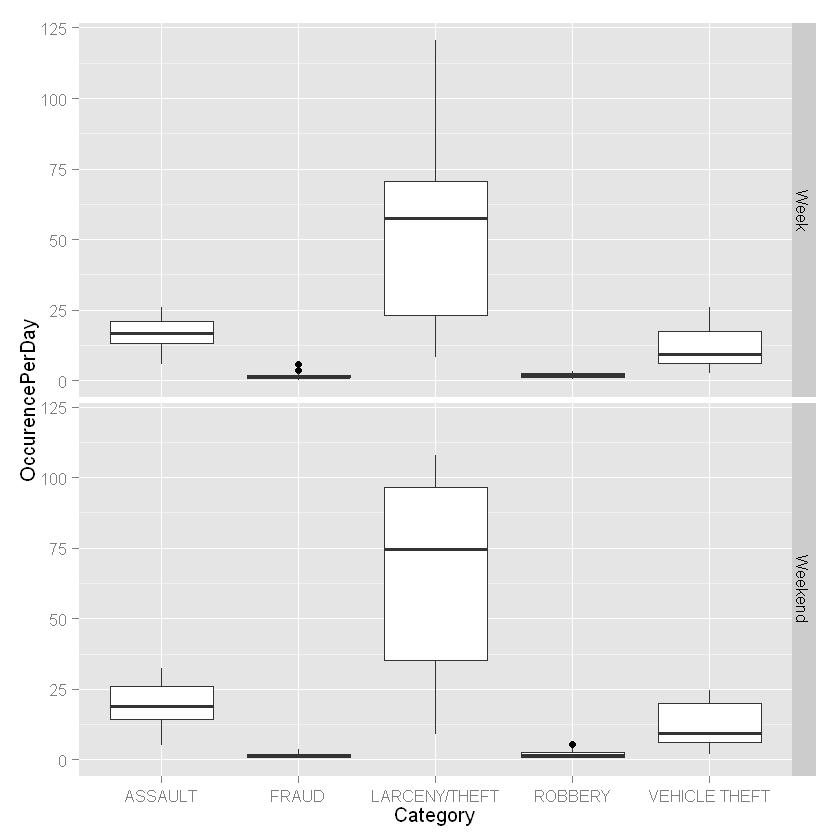

In [49]:
ggplot(CrimeTime, aes(Category ,OccurencePerDay)) + geom_boxplot() + facet_grid(DayTipe~ .)

##Crime patterns over the course of the day

We now represent the evolution of the crimes per hour for each hour of the day, split per day type and per crime category.
Taking into account the large differences in occurences between the different crime categories, the graphs have not been 
set at the same scale: the reader should keep this in mind when interpreting the graphs. 
The first observation that strikes us (with some notable exceptions that we discuss below) is that, generally speaking, the 
pattern of crime appears to be broadly similar during the week and during the weekends: from midnight on, there is a gradual drop 
in the occurences per hour, until around 5-6 AM. As all observations in this data set fall between the 1st of June and the 1st of
September, the time where crime per hour tends to increase again corresponds more or less to sunrise.
From then on, the occurences gradually increase during the day.
    
The exceptions are:
    
- In the case of "Fraud", the number of occurences is so small that one can raise the question whether it makes any sense to
    consider the number of occurences per hour at all. However, we observe a clear peak during the week days around noon. This 
    makes sense when one realizes that, in the case of white collar crime, it seldom makes sense to talk about the 
    "time of occurence" of a crime: these crimes usually take place over extended periods of time, up to several years. Therefore, the
    peak around noon probably simply represents an administrative convention, and does not indicate any real temporal variation. 
- For "Robbery" as well, the number of observations per hour is so small that it can be doubted whether disaggregation over the day is meaningful
    for this category (or even whether this should be a separate crime category at all).
- In the case of "vehicle theft", there is a first peak around 8-9 AM, followed by a second peak between 5PM and PM. Moreover, 
    during the weekends, there is also a peak around noon. These peaks can be better understood when one realises that these
    are usually also the daily peaks in traffic (for commuting during the week and shopping and leisure during the weekends). In 
    other words, these are the periods when people are the most likely to use their cars, and thus also observe that they
    have been stolen. Thus, these peaks probably represent peaks in the reporting of car thefts, rather than peaks in actual 
    thefts. Therefore, these observations are probably not very useful to guide police efforts.
- In the case of "Assault", "Larceny/theft" and "Robbery", the number of occurences at night tend to be larger during the weekends than during the week days. This probably reflects that there are more people awake and on the street (and thus morepotential victimes) during the nights in the weekends. 

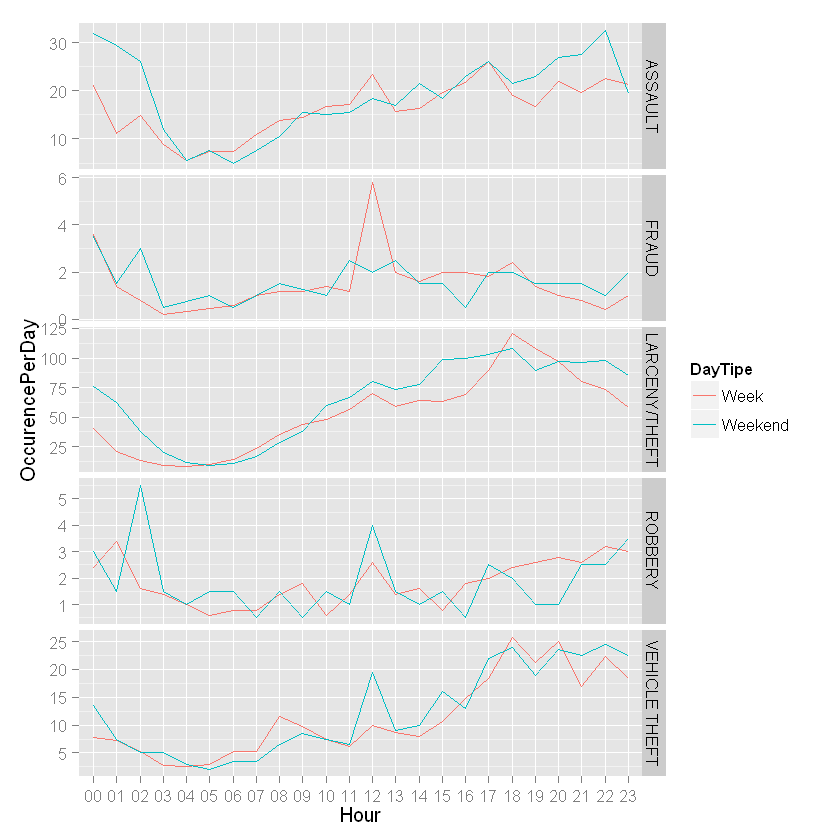

In [50]:
CrimeTimePlot <- ggplot(CrimeTime, aes(Hour,OccurencePerDay, group= DayTipe )) + geom_line(aes(colour=DayTipe ))
CrimeTimePlot + facet_grid(Category ~ ., scale = "free_y")

Let us now exclude the crime categories for which we have argued that the reported hour is unlikely to 
reveal much information about the actual hour of occurence ("Fraud", "Robbery" and "Vehicle theft").
We group the occurences per hour for weekdays and weekends.
For the two remaining categories, the general pattern of crime during the day is also confirmed when we estimate the trend line with 
    smooth linear regression ("loess").
    

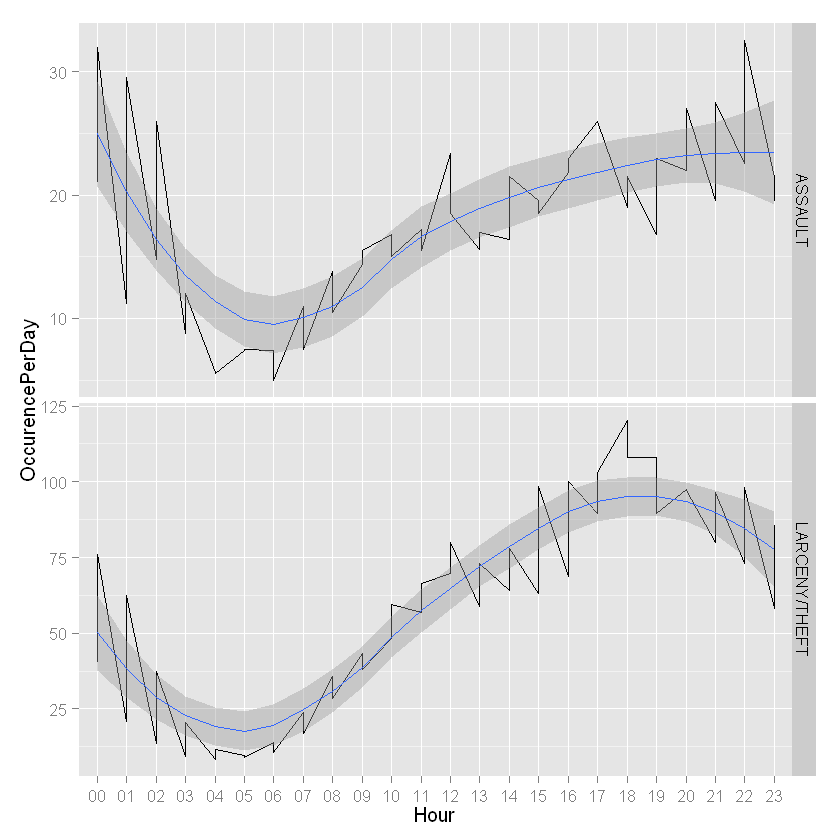

In [51]:
CrimeTimeRel <- CrimeTime[CrimeTime$Category %in% c("ASSAULT","LARCENY/THEFT"), ]
ggplot(CrimeTimeRel, aes(Hour,OccurencePerDay, group= 1)) + geom_line() + 
 facet_grid(Category ~ ., scale = "free_y") + geom_smooth(method = "loess")

## Correlation of occurences over time
A third way to look at the variation of the occurences over time, is to look at the correlation
between the occurences per hour (for each type of day) for the different crime categories.
The correlation matrix below confirms that the patterns during the day are positively correlated
for all crime categories. 
    
The correlations between the occurences of "fraud" and the
other crime categories are low, however. This is in line with our hypothesis that the reported hour 
for "fraud" is probably mainly an administrative convention. 
    
The correlation between the occurences of "robbery" and the other crime categories are also relatively low,
which is also in line with the hypothesis that the number of occurences per hour is simply too low
for a meaningfull analysis. 


Using OccurencePerDay as value column: use value.var to override.


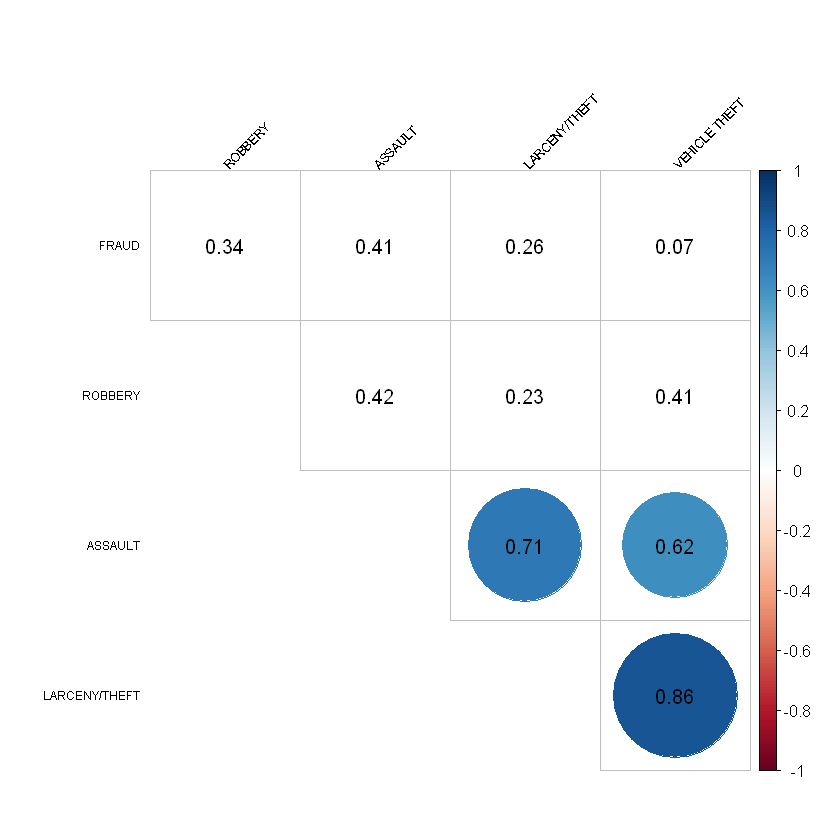

In [52]:
CrimeTimeCast <- dcast(CrimeTime, DayTipe + Hour ~ Category )
CrimeTimeCastCor <- CrimeTimeCast[ , CrimesConsidered]
cor_crime <- cor(CrimeTimeCastCor, use = "na.or.complete")
cor_crime <- corrplot(cor_crime, order="AOE", method="circle", tl.pos="lt", type="upper",        
tl.col="black", tl.cex=0.6, tl.srt=45, 
         addCoef.col="black", addCoefasPercent = FALSE,
         p.mat = 1-abs(cor_crime), sig.level=0.50, insig = "blank", diag = FALSE)  



##Extensions

We have also performed similar analyses to detect patterns over the course of weeks and over the whole
period covered in the dataset. As these steps have not revealed meaningful or interesting patterns, they
have been omitted here. However, they are available on simple request.